In [33]:
import numpy as np
import pandas as pd 

import os

In [34]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import requests as reqs
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint  # For gradient checkpointing
from torch.cuda.amp import autocast, GradScaler  # For mixed-precision training
import matplotlib.pyplot as plt
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import zipfile
import urllib.request
import shutil
import random
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


# Setting the device for PyTorch; use CUDA if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [35]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

# Read all classes from the file
classes = open(r"C:\Users\vihan\projects\final-one\models\classes_new.txt", 'r').read().splitlines()

# Use all class names (no slicing)
classes_all = classes

# Print total number of classes
print(f"Total classes: {len(classes_all)}")

# Define custom label encoder for all classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels.get(label)

# Initialize label encoder with all classes
encoder_all = Label_encoder(classes_all)

# Test the encoder
print(encoder_all.get_label(0), encoder_all.get_idx(encoder_all.get_label(0)))

# Print all classes with their index
for i in range(len(classes_all)):
    label = encoder_all.get_label(i)
    idx = encoder_all.get_idx(label)
    print(f"{i:02d}: {label}")

# Define custom dataset class
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)  # Convert to NumPy array for Albumentations

        label = encoder_all.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

Total classes: 28
beatroot 0
00: beatroot
01: beef_carpaccio
02: beef_tartare
03: beet_salad
04: cheese_plate
05: cheesecake
06: chicken_curry
07: chicken_wings
08: deviled_eggs
09: dhal
10: donuts
11: eggs_benedict
12: fish_and_chips
13: french_fries
14: fried_egg
15: grilled_salmon
16: hot_dog
17: ice_cream
18: kottu
19: lasagna
20: macaroni_and_cheese
21: omelette
22: pork_chop
23: red_rice
24: samosa
25: steak
26: sushi
27: white_rice


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Example: Replace with your actual CSV or DataFrame
df = r"C:\Users\vihan\Desktop\Dataset" # or use an existing DataFrame
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


TypeError: string indices must be integers, not 'str'

In [17]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    img_path = r"C:\Users\vihan\projects\food set\images"
    # Split class and image id
    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    for idx, img in enumerate(imgs):
        if encoder_108.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"
    # Build the full path correctly
    full_path = [os.path.join(img_path, img[0], img[1] + ".jpg") for img in imgs]
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])
    imgs['path'] = full_path
    imgs = shuffle(imgs)
    return imgs

In [46]:
# Preparing training and testing dataframes
train_imgs = prep_df(r"C:\Users\vihan\projects\food set\train_names.txt")
test_imgs = prep_df(r"C:\Users\vihan\projects\food set\test_names.txt")
# Printing the count of images per label in the training set
print(train_imgs.groupby(["label"]).count())

                path
label               
apple_pie        796
baby_back_ribs   810
baklava          792
beatroot          75
beef_carpaccio   805
...              ...
takoyaki         804
tiramisu         812
tuna_tartare     819
waffles          820
white_rice        23

[108 rows x 1 columns]


In [47]:
train_imgs.head(3)

,label,path
967042,tiramisu,C:\Users\vihan\projects\food set\images\tirami...
1363933,chocolate_cake,C:\Users\vihan\projects\food set\images\chocol...
993558,gyoza,C:\Users\vihan\projects\food set\images\gyoza\...


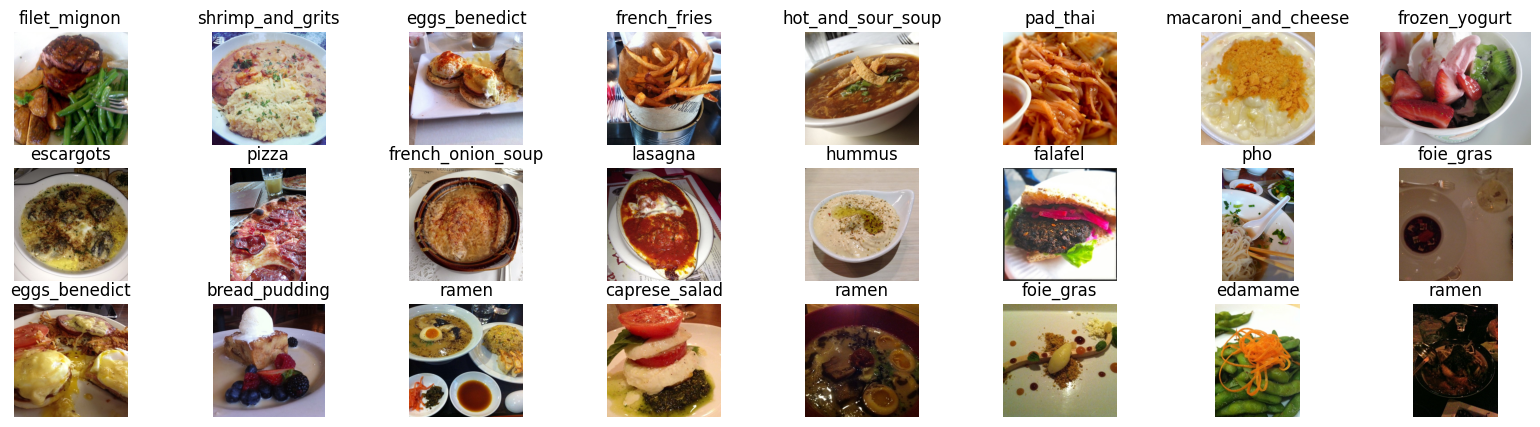

In [48]:
plt.figure(figsize=(20, 5))
num_rows = 3
num_cols = 8
for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])
    label = train_imgs.label.iloc[random_idx]
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [52]:
# Importing necessary libraries
import os
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.utils import shuffle
from PIL import Image
import random
from torch.utils.checkpoint import checkpoint_sequential
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR

# Setting device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reading class names and defining the first 20 classes + 'other'
classes = open(r"C:\Users\vihan\projects\food set\classes.txt", 'r').read().splitlines()

# Custom label encoder for 21 classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}
    def get_label(self, idx):
        return list(self.labels.keys())[idx]
    def get_idx(self, label):
        return self.labels.get(label)

# Custom Dataset Class for handling image data
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms without using a named argument for torchvision.transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [53]:
# Function to prepare a DataFrame from a given path with image paths and labels
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    img_path =  r"C:\Users\vihan\projects\food set\images"
    full_path = [img_path + img + ".jpg" for img in array]
    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    for idx, img in enumerate(imgs):
        if encoder_108.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"      
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])      
    imgs['path'] = full_path
    imgs = shuffle(imgs)
    return imgs

# Preparing training and testing DataFrames
train_imgs = prep_df(r"C:\Users\vihan\projects\food set\train_names.txt")
test_imgs = prep_df(r"C:\Users\vihan\projects\food set\test_names.txt")

# Custom cutout augmentation class
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

In [54]:
# Data augmentation and transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(n_holes=1, length=16)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [55]:
# Data loaders
trainset = Food21(train_imgs, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

testset = Food21(test_imgs, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

In [61]:
# Gradient Checkpointed ResNet152 Model
class CheckpointedResNet152(nn.Module):
    def __init__(self, num_classes=21):
        super(CheckpointedResNet152, self).__init__()
        base_model = models.resnet152(weights='IMAGENET1K_V1')
       
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
       
        self.avgpool = base_model.avgpool
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
       
        x = checkpoint_sequential(self.layer1, segments=1, input=x)
        x = checkpoint_sequential(self.layer2, segments=1, input=x)
        x = checkpoint_sequential(self.layer3, segments=1, input=x)
        x = checkpoint_sequential(self.layer4, segments=1, input=x)
       
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [62]:
# Initialize model, criterion, optimizer, scaler, and scheduler
model = CheckpointedResNet152(num_classes=21).to(device)
scaler = GradScaler()
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Scheduler with warm-up and cosine annealing
warmup_epochs = 3
total_epochs = 11
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs),
        CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    ],
    milestones=[warmup_epochs]
)

In [ ]:
# Training and testing functions
def train(epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in tqdm(trainloader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_accuracy = 100. * correct_train / total_train
    print(f'Training Loss: {running_loss/len(trainloader):.3f} | Training Accuracy: {train_accuracy:.2f}%')

def test(epoch):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc=f"Testing Epoch {epoch + 1}"):
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast(device_type='cuda'):
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_accuracy = 100. * correct_test / total_test
    print(f'Test Accuracy after Epoch {epoch + 1}: {test_accuracy:.2f}%')
    return test_accuracy

# Training loop
best_acc = 0.0

for epoch in range(total_epochs):
    train(epoch)
    acc = test(epoch)
    scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'resnet152_food21_best.pt')
        print(f"Best model saved with accuracy: {best_acc:.2f}%")

print("Training completed.")

Training Epoch 1:   0%|          | 0/2535 [00:00<?, ?it/s]